# Method of Simulated Moments (MSM) for Structural Estimation

### Steps of MSM estimation
1. Load empirical data
2. Define a function to calculate empirical moments from the data
3. Calculate the covariance matrix of the empirical moments (for the weighting matrix)
4. Define a `HARK` agent type with the model parameters to be estimated
5. Define a function to simulate the model and calculate the simulated moments
6. Estimate the model parameters by minimizing the distance between the empirical and simulated moments

In [1]:
from __future__ import annotations

from copy import copy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from estimagic.utilities import read_pickle
from HARK.Calibration.Income.IncomeTools import (
    Cagetti_income,
    parse_income_spec,
    parse_time_params,
)
from HARK.Calibration.life_tables.us_ssa.SSATools import parse_ssa_life_table
from HARK.Calibration.SCF.WealthIncomeDist.SCFDistTools import (
    income_wealth_dists_from_scf,
)
from HARK.ConsumptionSaving.ConsBequestModel import BequestWarmGlowConsumerType
from HARK.ConsumptionSaving.ConsIndShockModel import init_lifecycle
from HARK.utilities import plot_funcs

figs_dir = Path("../../content/slides/figures/")
figs_dir.mkdir(parents=True, exist_ok=True)

## 1. Load empirical data

To avoid the expensive calculation and recalculation of the empirical moments and the covariance matrix, we calculate these in a separate notebook and save them to be loaded here.

## 2. Calculate Moments


<Axes: xlabel='age_lbl'>

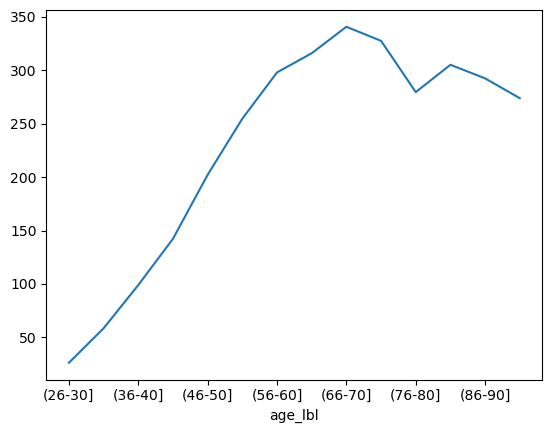

In [2]:
empirical_moments = pd.read_pickle("networth_mom.pkl")
empirical_moments.plot()

## 3. Calculate the covariance matrix of empirical moments

In [3]:
moments_cov = pd.read_pickle("networth_cov.pkl")

## 4. Define an agent type to simulate data

In [4]:
birth_age = 25
death_age = 100
adjust_infl_to = 1992
income_calib = Cagetti_income
education = "HS"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True,
)

# Initial distribution of wealth and permanent income
dist_params = income_wealth_dists_from_scf(
    base_year=adjust_infl_to,
    age=birth_age,
    education=education,
    wave=1995,
)

# We need survival probabilities only up to death_age-1, because survival
# probability at death_age is 0.
liv_prb = parse_ssa_life_table(
    female=True,
    cross_sec=True,
    year=2004,
    min_age=birth_age,
    max_age=death_age - 1,
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

# Update all the new parameters
params = copy(init_lifecycle)
params.update(time_params)
params.update(dist_params)
params.update(income_params)
params["LivPrb"] = liv_prb
params["AgentCount"] = 1_000
params["T_sim"] = 75
params["track_vars"] = ["aNrm", "bNrm", "cNrm", "pLvl", "t_age", "mNrm"]
params["PermGroFacAgg"] = 1.0


### Define some initial constraints
params["BeqCRRA"] = 0.0
params["BeqCRRATerm"] = 0.0
params["BeqFac"] = 0.0
params["BeqFacTerm"] = 0.0
params["BeqShift"] = 0.0
params["BeqShiftTerm"] = 0.0

In [5]:
LifeCycleAgent = BequestWarmGlowConsumerType(**params)
LifeCycleAgent.solve()

Consumption functions


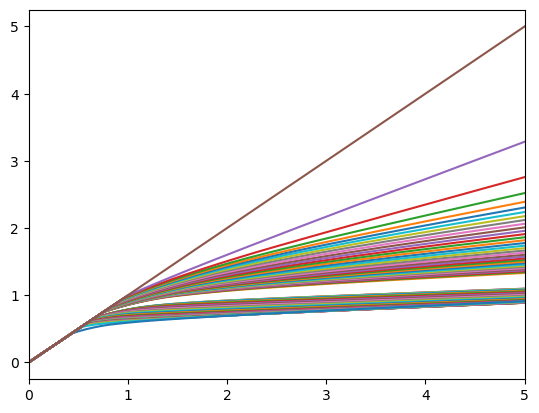

In [6]:
LifeCycleAgent.unpack("cFunc")
# Plot the consumption functions
print("Consumption functions")
plot_funcs(LifeCycleAgent.cFunc, 0, 5)

In [7]:
# Turn off death for simulation
LifeCycleAgent.LivPrb = [1.0] * LifeCycleAgent.T_cycle

# Run the simulations
LifeCycleAgent.initialize_sim()
history = LifeCycleAgent.simulate()

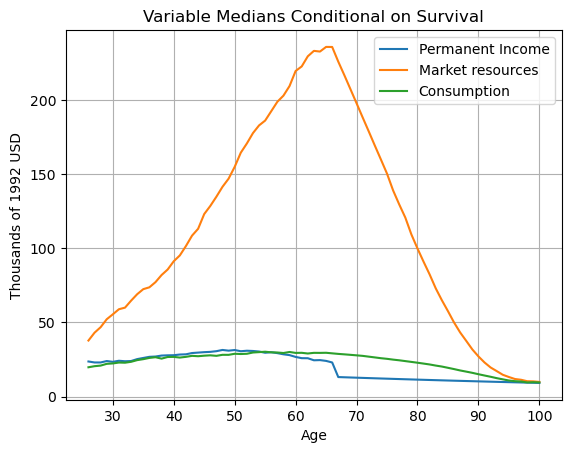

In [8]:
raw_data = {
    "Age": history["t_age"].flatten() + birth_age,
    "pIncome": history["pLvl"].flatten(),
    "nrmM": history["mNrm"].flatten(),
    "nrmC": history["cNrm"].flatten(),
}

sim_data = pd.DataFrame(raw_data)
sim_data["Cons"] = sim_data.nrmC * sim_data.pIncome
sim_data["M"] = sim_data.nrmM * sim_data.pIncome

# Find the mean of each variable at every age
AgeMeans = sim_data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel(f"Thousands of {adjust_infl_to} USD")
plt.title("Variable Medians Conditional on Survival")
plt.grid()

In [9]:
age_groups = [
    list(range(start, start + 5)) for start in range(birth_age + 1, 95 + 1, 5)
]

# generate labels as (25,30], (30,35], ...
age_labels = [f"({group[0]-1},{group[-1]}]" for group in age_groups]

# Generate mappings between the real ages in the groups and the indices of simulated data
age_mapping = dict(zip(age_labels, map(np.array, age_groups)))

In [10]:
age_mapping

{'(25,30]': array([26, 27, 28, 29, 30]),
 '(30,35]': array([31, 32, 33, 34, 35]),
 '(35,40]': array([36, 37, 38, 39, 40]),
 '(40,45]': array([41, 42, 43, 44, 45]),
 '(45,50]': array([46, 47, 48, 49, 50]),
 '(50,55]': array([51, 52, 53, 54, 55]),
 '(55,60]': array([56, 57, 58, 59, 60]),
 '(60,65]': array([61, 62, 63, 64, 65]),
 '(65,70]': array([66, 67, 68, 69, 70]),
 '(70,75]': array([71, 72, 73, 74, 75]),
 '(75,80]': array([76, 77, 78, 79, 80]),
 '(80,85]': array([81, 82, 83, 84, 85]),
 '(85,90]': array([86, 87, 88, 89, 90]),
 '(90,95]': array([91, 92, 93, 94, 95])}

## 5. Define a function to calculate simulated moments

In [11]:
def simulate_moments(params, agent=None):
    agent.assign_parameters(**params)  # new guess
    agent.LivPrb = liv_prb  # perceived mortality
    agent.BeqCRRA = agent.CRRA

    agent.update()
    agent.solve()

    agent.LivPrb = [1.0] * agent.T_cycle  # ignore mortality
    agent.initialize_sim()
    history = agent.simulate()

    raw_data = {
        "age": history["t_age"].flatten() + birth_age,
        "b_nrm": history["bNrm"].flatten(),
        "p_lvl": history["pLvl"].flatten(),
    }

    sim_data = pd.DataFrame(raw_data)
    sim_data["Wealth"] = sim_data.b_nrm * sim_data.p_lvl

    sim_data["Age_grp"] = pd.cut(
        sim_data.age,
        bins=range(birth_age + 1, 97, 5),
        labels=age_labels,
        right=False,
    )

    sim_data = sim_data.dropna()

    return sim_data.groupby("Age_grp", observed=False)["Wealth"].median()

<Axes: xlabel='age_lbl'>

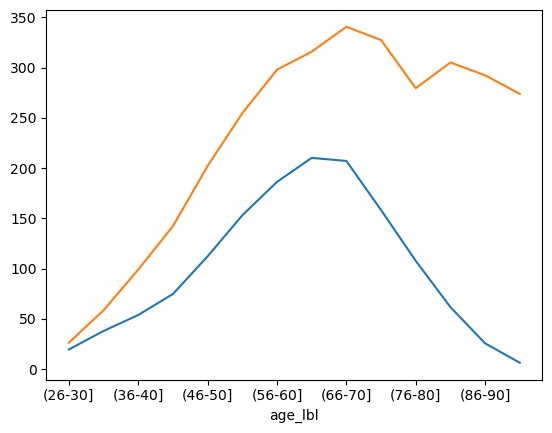

In [12]:
simulate_moments({}, agent=LifeCycleAgent).plot()
empirical_moments.plot()

## 6. Estimate the model parameters

In [13]:
init_params = {
    "CRRA": 3.78,
    "DiscFac": 0.97,
    # Warm Glow bequest parameters
    "BeqFac": 70.76,
    "BeqShift": 1.63,
}
lower_bounds = {
    "CRRA": 1.0,
    "DiscFac": 0.9,
    "BeqFac": 50.0,
    "BeqShift": 0.0,
}
upper_bounds = {
    "CRRA": 5.0,
    "DiscFac": 1.0,
    "BeqFac": 100.0,
    "BeqShift": 10.0,
}


# res = estimate_msm(
#     LifeCycleAgent,
#     init_params,
#     empirical_moments,
#     moments_cov,
#     simulate_moments,
#     optimize_options={
#         "algorithm": "scipy_lbfgsb",
#         "error_handling": "continue",
#         "numdiff_options": {"n_cores": 24},
#         "multistart": True,
#     },
#     estimagic_options={
#         "lower_bounds": lower_bounds,
#         "upper_bounds": upper_bounds,
#         "numdiff_options": {"n_cores": 24},
#     },
# )

# res.to_pickle("fullbeq_results.pkl")

res = read_pickle("fullbeq_results.pkl")

In [14]:
pd.concat(res.summary()).to_html("../../content/slides/tables/fullbeq_results.html")

In [15]:
res.params

{'CRRA': 2.155237966339853,
 'DiscFac': 0.9709864400317447,
 'BeqFac': 75.56667334503045,
 'BeqShift': 2.0564862750710926}

In [16]:
pd.DataFrame(res.cov())

,CRRA,DiscFac,BeqFac,BeqShift
CRRA,0.027012086812560916,-0.0003065328377841059,5.522963367452015,0.08955096718927386
DiscFac,-0.0003065328377840978,4.018372320846756e-06,-0.06347799171495323,-0.0005304126778983582
BeqFac,5.5229633674520535,-0.06347799171495538,1172.3053247589396,23.070730960554826
BeqShift,0.0895509671892782,-0.0005304126778984375,23.07073096055556,1.5773004121385747


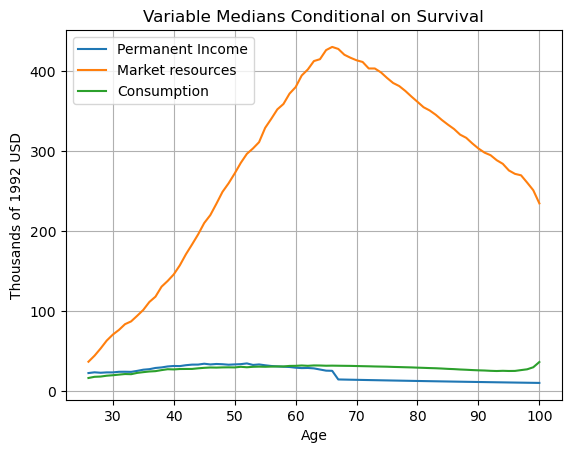

In [17]:
LifeCycleAgent.assign_parameters(**res.params)
LifeCycleAgent.LivPrb = liv_prb
LifeCycleAgent.update()
LifeCycleAgent.solve()
LifeCycleAgent.LivPrb = [1.0] * LifeCycleAgent.T_cycle
LifeCycleAgent.initialize_sim()
history = LifeCycleAgent.simulate()

raw_data = {
    "Age": history["t_age"].flatten() + birth_age,
    "pIncome": history["pLvl"].flatten(),
    "nrmM": history["mNrm"].flatten(),
    "nrmC": history["cNrm"].flatten(),
}

sim_data = pd.DataFrame(raw_data)
sim_data["Cons"] = sim_data.nrmC * sim_data.pIncome
sim_data["M"] = sim_data.nrmM * sim_data.pIncome

# Find the mean of each variable at every age
AgeMeans = sim_data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel(f"Thousands of {adjust_infl_to} USD")
plt.title("Variable Medians Conditional on Survival")
plt.grid()

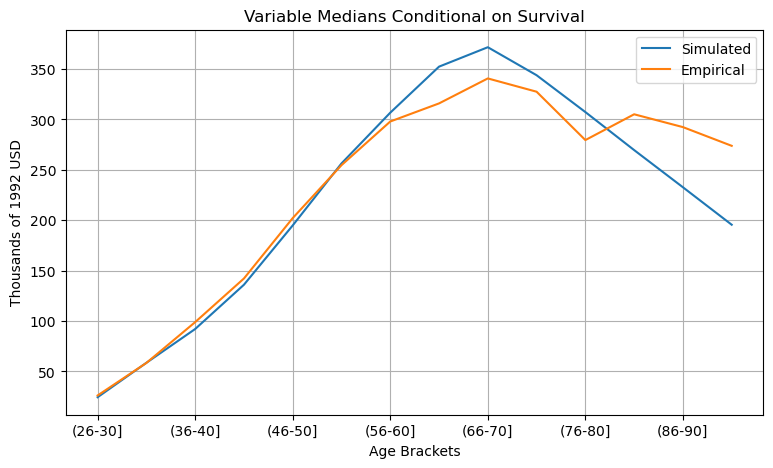

In [18]:
simulate_moments(res.params, agent=LifeCycleAgent).plot()
empirical_moments.plot(figsize=(9, 5))

plt.legend(["Simulated", "Empirical"])
plt.xlabel("Age Brackets")
plt.ylabel(f"Thousands of {adjust_infl_to} USD")
plt.title("Variable Medians Conditional on Survival")
plt.grid()

plt.savefig(figs_dir / "fullbeq_results.svg")

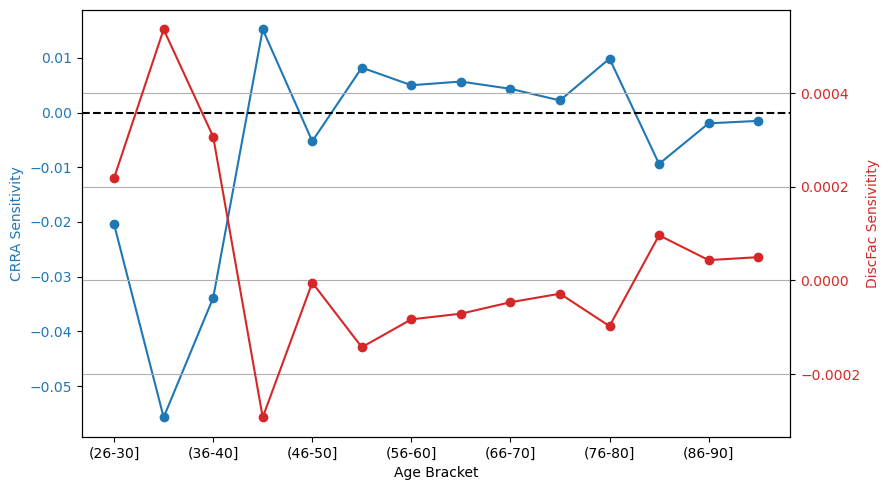

In [19]:
# Assuming df is your DataFrame and 'A' and 'B' are columns in df
sensitivity = res.sensitivity(return_type="dataframe").T

fig, ax1 = plt.subplots(figsize=(9, 5))

color = "tab:blue"
ax1.set_xlabel("Age Bracket")
ax1.set_ylabel("CRRA Sensitivity", color=color)
ax1.plot(sensitivity.index, sensitivity["CRRA"], color=color, marker="o")
ax1.tick_params(axis="y", labelcolor=color)

# Add a horizontal dashed line at y=0 on first axis
ax1.axhline(0, color="black", linestyle="--")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:red"
ax2.set_ylabel(
    "DiscFac Sensivitity",
    color=color,
)  # we already handled the x-label with ax1
ax2.plot(sensitivity.index, sensitivity["DiscFac"], color=color, marker="o")
ax2.tick_params(axis="y", labelcolor=color)

# Make sure both y-axes have the same limits
ax1.set_ylim(ax1.get_ylim())
ax2.set_ylim(ax2.get_ylim())

# Reduce the number of x-ticks
plt.xticks(sensitivity.index[::2])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid()
plt.savefig(figs_dir / "fullbeq_sensitivity.svg")